In [431]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [432]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

In [433]:
path="datasets/ofg_family/"
randomiser = np.random.RandomState(123)

In [434]:
def generate_image(family_dir):
    dic={}
    sub=[a for a in listdir(path+"/"+family_dir)]
    
    for ele in sub:
        mypath = path+"/"+family_dir+"/"+ele+"/"
        onlyfiles = [mypath+f for f in listdir(mypath)]
        
        addr = randomiser.choice(onlyfiles)
        original_img = np.array(Image.open(addr).resize((64,64),Image.ANTIALIAS))
        if ele[0].lower()=='f':
            dic['father'] = original_img
        elif ele[0].lower()=='m':
            dic['mother'] = original_img
        elif ele.lower()=='child_male':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele.lower()=='child_female':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    
    for family in families_batch:
        res = generate_image(family)
        if( res != None):
            np_images.append(res)
    
    return np_images

In [435]:
for r, d, f in os.walk(path):
        all_families=d
        break

randomiser.shuffle(all_families)

train_families = all_families[:-500]
test_families = all_families[-500:]

In [436]:
OUTPUT_CHANNELS = 3

In [437]:
mean = 0.
std_dev = 0.02
lr = 0.0005
b1 = 0.5

In [438]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [439]:
def gen_downsample_noise(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())

    return result

In [440]:
def gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [441]:
sd_random_normal_init = 0.02

In [442]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=True),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
    down_stack_noise =[
#   z = 4x4x64
    gen_downsample_noise(64,4,apply_batchnorm=True), #8x8x64
    gen_downsample_noise(32,4,apply_batchnorm=True) #16x16x32      
    ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=(64,64,3))
    
    father = tf.reshape(inputs[0],(1,64,64,3))
    mother = tf.reshape(inputs[1],(1,64,64,3))

    
#     create noise 4x4x64
#     noise = tf.random.normal((1,4,4,64),mean=0.0,stddev=1.0,dtype=tf.dtypes.float32)
#     print(noise.shape)
    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
#     print(x2.shape)
    
#     n = noise
#     for down in down_stack_noise:
#         print(n.shape)
#         n = down(n)
#     print(n.shape)
#     print("NOISE STACK DONE")
    
    final = concat([x1,x2])
    final = final_conv[0](final)
    
    final = last(final)

    return tf.keras.Model(inputs=inputs, outputs=final)

In [443]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [444]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [463]:
def train_encoder(inp_batch, target_batch,b_size):
    with tf.GradientTape() as enc_tape:
        
        inp_batch = tf.unstack(inp_batch)
        target_batch = tf.unstack(target_batch)

        encoder_loss =tf.Variable(0,dtype='float32')

        for idx,inputs in enumerate(inp_batch):
            gen_output = encoder(inputs, training=True)
            print(gen_output.shape)
            encoder_loss = encoder_loss + tf.reduce_mean(tf.abs(target_batch[idx] - gen_output))
            

        encoder_loss/=b_size
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,encoder.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))
    


In [464]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            loss_i =np.array([])
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)

            X_train = tf.convert_to_tensor([batch_data[:,0],batch_data[:,1]],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            train_encoder(X_train,Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [465]:
train_dataset = all_families[:-500]
test_dataset = all_families[-500:]
EPOCHS = 20
batch = 450
encoder = EncoderNN()

with tf.device('/cpu:0'):
    fit_encoder(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 1_______________________________
Generated batch (450, 4, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
ENCODER_LOSS:  0.0017528229
Trained for batch 1/3
Generated batch (450, 4, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
ENCODER_LOSS:  0.002378102
Trained for batch 2/3
Generated batch (450, 4, 64, 64, 3)


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 64, 64, 3)
-0.52034783
0.7778021


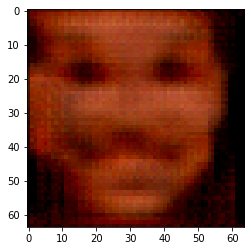

In [378]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
print(temp.shape)
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.67389274
0.67460304


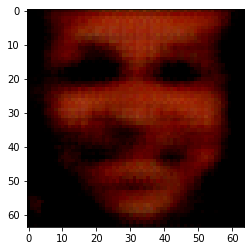

In [363]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.6218811
0.68083906


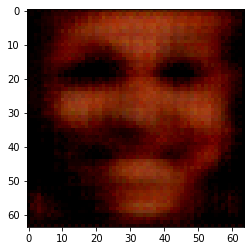

In [361]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.36182126
0.698657


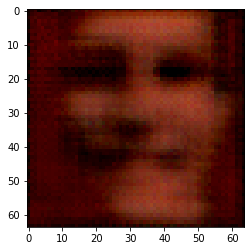

In [357]:
family_data = generate_image(all_families[0])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.3843608
0.68435824


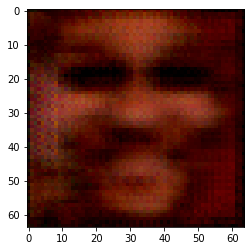

In [332]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.45008188
0.702217


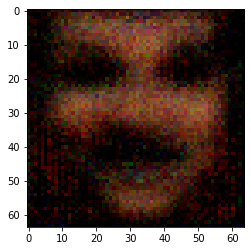

In [326]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.5110681
0.7665162


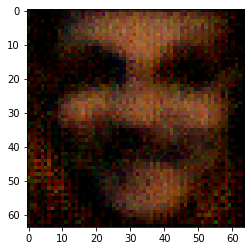

In [226]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.47459885
0.67357314


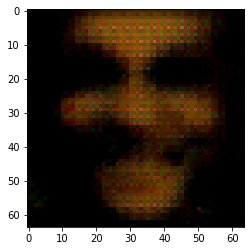

In [176]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

In [ ]:
# epochs = 10 bs 250 lr 0.002 mean = 0.02
family_data = generate_image(all_families[700])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=False)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.99999595
1.0000001


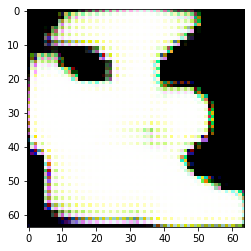

In [108]:
# epoch 10 batch = 250 mean 0.04 lr 1e-4 beta_1= 0.5
family_data = generate_image(all_families[700])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=False)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.7836988
0.9999595


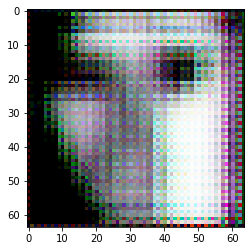

In [93]:
# epoch 10 batch = 250 mean 0.02 lr 0.0005
family_data = generate_image(all_families[700])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=False)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.0000001
0.9999994


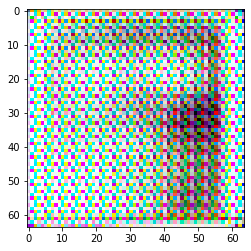

In [60]:
# epoch 20 batch = 400
family_data = generate_image(all_families[700])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=False)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.0000001
0.9998396


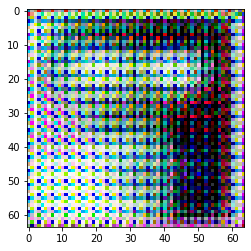

In [52]:
# epochs : 10 batch size 250
family_data = generate_image(all_families[700])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=False)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.0000001
0.99984396


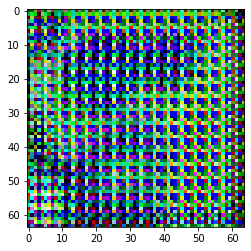

In [44]:
#epochs = 4 batch_size : 250 
family_data = generate_image(all_families[700])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=False)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

In [447]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [448]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [487]:
def Discriminator():
    
    par1 = tf.keras.layers.Input(shape=[64, 64, 3], name='father_image')
    par2 = tf.keras.layers.Input(shape=[64, 64, 3], name='mother_image')
    target = tf.keras.layers.Input(shape=[64, 64, 3], name='target_image')
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False),
    disc_downsample_parent_target(64,4,apply_batchnorm=True)
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4,strides=4,padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')
    
    
    father = tf.reshape(par1,(1,64,64,3))
    mother = tf.reshape(par2,(1,64,64,3))
    real_child = tf.reshape(target,(1,64,64,3))
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = real_child
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is 1x16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
    
    output = last(x4)
#     print(output.shape)

    return tf.keras.Model(inputs=[par1,par2,target], outputs=output)

In [488]:
discriminator = Discriminator()

In [489]:
family_data = generate_image(all_families[126])
p1 = tf.cast(family_data[0], tf.float32)
p2 = tf.cast(family_data[1], tf.float32)
c = tf.cast(family_data[2], tf.float32)

discriminator = Discriminator()
with tf.device('/cpu:0'):
    disc_out = discriminator(inputs = [p1,p2,c], training=True)
    print(disc_out.numpy()[0][0][0])

[0.5253006]


In [490]:
LAMBDA = 100

In [491]:
loss_object = tf.keras.losses.BinaryCrossentropy()

In [492]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [493]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output,dtype=tf.float32), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output,dtype=tf.float32), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [494]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output,dtype=tf.float32), disc_generated_output)
  # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

In [495]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [504]:
def train_step(inp_batch, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        inp_batch = tf.unstack(inp_batch)
        target_batch = tf.unstack(target_batch)

        gen_loss =tf.Variable(0,dtype='float32')
        disc_loss =tf.Variable(0,dtype='float32')
        
        for idx,inputs in enumerate(inp_batch):
            gen_output = encoder(inputs, training=True)
#             gen_output shape is 1x64x64x3

            disc_real_output = discriminator([inputs[0],inputs[1],target_batch[idx]], training=True)
#             print(disc_real_output)
            disc_generated_output = discriminator([inputs[0],inputs[1],tf.squeeze(gen_output)], training=True)
#             print(disc_generated_output)
            gen_loss = gen_loss + generator_loss(disc_generated_output, gen_output, target_batch[idx])
            disc_loss = disc_loss + discriminator_loss(disc_real_output, disc_generated_output)


        gen_loss/=b_size
        disc_loss/=b_size
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,encoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [505]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))

            print("Generated batch", batch_data.shape)

            X_train = tf.convert_to_tensor([batch_data[:,0],batch_data[:,1]],dtype =tf.float32)
#             print("Xtrain",X_train.shape)
#             print("Batch converted to tensor")

            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_train,Y_train,batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [506]:
concat = tf.keras.layers.Concatenate()

In [521]:
train_dataset = all_families[:-500]
test_dataset = all_families[-500:]
EPOCHS = 6
batch = 250
encoder = EncoderNN()
discriminator = Discriminator()

In [522]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=encoder,
                                 discriminator=discriminator)

In [ ]:
with tf.device('/cpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 0_______________________________
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 114.58116
DISC_LOSS 0.012209839
Trained for batch 1/6
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 140.54393
DISC_LOSS 0.02831627
Trained for batch 2/6
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 115.70484
DISC_LOSS 0.0010920321
Trained for batch 3/6
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 111.72281
DISC_LOSS 0.021396954
Trained for batch 4/6
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 104.005745
DISC_LOSS 0.0039771465
Trained for batch 5/6
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 113.04234
DISC_LOSS 0.0051871664
Trained for batch 6/6
______________________________EPOCH 1_______________________________
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 114.514175
DISC_LOSS 0.0013687874
Trained for batch 1/6
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 140.52057
DISC_LOSS 0.012286088
Trained for batch 2/6
Generated batch (250, 4, 64, 64, 3)
GEN_LOSS 107.089005
DISC_LOSS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(-0.68311995, shape=(), dtype=float32)
tf.Tensor(0.84348685, shape=(), dtype=float32)


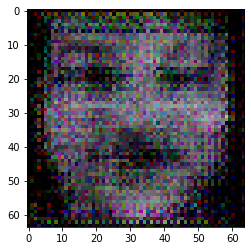

In [520]:
family_data = generate_image(all_families[126])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
with tf.device('/cpu:0'):
    gen_output = encoder(inp, training=True)
print(tf.reduce_min(gen_output))
print(tf.reduce_max(gen_output))
plt.imshow(gen_output[0,...])